# 서브그래프 추가 및 사용 방법

SubGraph 를 사용하면 여러 구성 요소를 포함하는 복잡한 시스템을 구축할 수 있으며, 이러한 구성 요소 자체가 그래프가 될 수 있습니다. SubGraph 의 일반적인 사용 사례는 멀티 에이전트 시스템 구축입니다.

SubGraph 를 추가할 때 주요 고려사항은 상위 그래프와 SubGraph 가 어떻게 통신하는지, 즉 그래프 실행 중에 상태(State) 를 서로 어떻게 전달하는지입니다. 

다음 두 가지 시나리오가 있습니다.

* 상위 그래프와 서브그래프가 **스키마 키를 공유**하는 경우. 이 경우 **컴파일된 서브그래프로 노드를 추가** 할 수 있습니다
* 상위 그래프와 서브그래프가 **서로 다른 스키마**를 가지는 경우. 이 경우 **서브그래프를 호출하는 노드 함수를 추가** 해야 합니다. 
 
이는 상위 그래프와 서브그래프가 서로 다른 상태 스키마를 가지고 있고 서브그래프를 호출하기 전후에 상태를 변환해야 할 때 유용합니다.

아래에서 각 시나리오에 대한 서브그래프 추가 방법을 보여드리겠습니다.

## 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Modules")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Modules


## Case 1: 스키마 키를 공유하는 경우

- 컴파일된 SubGraph 로 노드 추가하기

상위 그래프와 서브그래프가 공유 상태 키(State Key) 를 통해 통신하는 것이 일반적인 사례입니다. 

예를 들어, **멀티 에이전트 시스템** 에서 에이전트들은 주로 공유된 `messages` 키를 통해 통신합니다.

서브그래프가 상위 그래프와 상태 키를 공유하는 경우, 다음 단계에 따라 그래프에 추가할 수 있습니다.

1. 서브그래프 워크플로우를 정의하고(아래 예시의 `subgraph_builder`) 컴파일
2. 상위 그래프 워크플로우를 정의할 때 `.add_node` 메서드에 컴파일된 서브그래프 전달

그럼, 아래에서 간단한 예시를 살펴보겠습니다.

In [3]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict


# 서브그래프 상태 정의를 위한 TypedDict 클래스, 부모 그래프와 공유되는 name 키와 서브그래프 전용 family_name 키 포함
class ChildState(TypedDict):
    name: str  # 부모 그래프와 공유되는 상태 키
    family_name: str


# 서브그래프의 첫 번째 노드, family_name 키에 초기값 설정
def subgraph_node_1(state: ChildState):
    return {"family_name": "Lee"}


# 서브그래프의 두 번째 노드, 서브그래프 전용 family_name 키와 공유 name 키를 결합하여 새로운 상태 생성
def subgraph_node_2(state: ChildState):
    # 서브그래프 내부에서만 사용 가능한 family_name 키와 공유 상태 키 name를 사용하여 업데이트 수행
    return {"name": f'{state["name"]} {state["family_name"]}'}


# 서브그래프 구조 정의 및 노드 간 연결 관계 설정
subgraph_builder = StateGraph(ChildState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()

그래프를 시각화합니다.

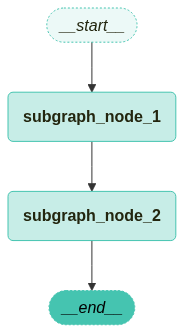

In [4]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(subgraph, xray=True)

In [5]:
# 부모 그래프의 상태 정의를 위한 TypedDict 클래스, name 키만 포함
class ParentState(TypedDict):
    name: str
    company: str


# 부모 그래프의 첫 번째 노드, name 키의 값을 수정하여 새로운 상태 생성
def node_1(state: ParentState):
    return {"name": f'My name is {state["name"]}'}


# 부모 그래프 구조 정의 및 서브그래프를 포함한 노드 간 연결 관계 설정
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
# 컴파일된 서브그래프를 부모 그래프의 노드로 추가
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()

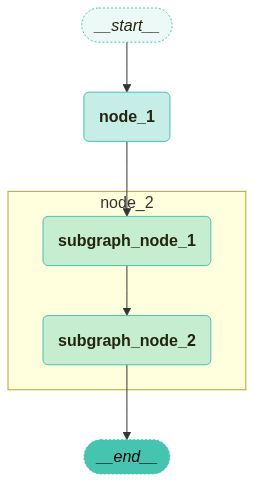

In [6]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph, xray=True)

In [7]:
# 그래프 스트림에서 청크 단위로 데이터 처리 및 각 청크 출력
for chunk in graph.stream({"name": "Teddy"}):
    print(chunk)

{'node_1': {'name': 'My name is Teddy'}}
{'node_2': {'name': 'My name is Teddy Lee'}}


상위 그래프의 최종 출력에는 하위 그래프 호출의 결과가 포함되어 있습니다. 

이때, 하위 그래프의 출력을 확인하려면 스트리밍 시 `subgraphs=True`를 지정하면 됩니다.

In [8]:
# 그래프 스트리밍 처리를 통한 서브그래프 데이터 청크 단위 순차 출력
# subgraphs 파라미터를 True로 설정하여 하위 그래프 포함 스트리밍 처리
for chunk in graph.stream({"name": "Teddy"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'name': 'My name is Teddy'}})
(('node_2:cefbf205-8390-2793-3b98-2afa1e56ec1f',), {'subgraph_node_1': {'family_name': 'Lee'}})
(('node_2:cefbf205-8390-2793-3b98-2afa1e56ec1f',), {'subgraph_node_2': {'name': 'My name is Teddy Lee'}})
((), {'node_2': {'name': 'My name is Teddy Lee'}})


## Case 2: 스키마 키를 공유하지 않는 경우

- 하위 그래프를 호출하는 노드 함수 추가

더 복잡한 시스템의 경우, 상위 그래프와 완전히 다른 스키마를 가진 하위 그래프를 정의해야 할 수 있습니다(공유되는 상태 키가 없는 경우 입니다). 

이러한 경우라면, **하위 그래프를 호출하는 노드 함수**를 정의해야 합니다. 

이 함수는 하위 그래프를 호출하기 전에 상위 상태(Parent State) 를 하위 그래프 상태(Child State) 로 변환하고, 노드에서 상태 업데이트를 반환하기 전에 결과를 다시 상위 상태(Parent State) 로 변환해야 합니다.

아래에서 노드 내부에서 하위 그래프를 호출하도록 원래 예제를 수정하는 방법을 보여줍니다.

**참고**

- 동일한 노드 내에서 두 개 이상의 `subgraph`를 호출할 수 **없습니다**.

In [9]:
# 서브그래프의 상태 타입 정의 (부모 그래프와 키를 공유하지 않음)
class ChildState(TypedDict):
    # 부모 그래프와 공유되지 않는 키들
    name: str


# 서브그래프의 첫 번째 노드: name 키에 초기값 설정
def subgraph_node_1(state: ChildState):
    return {"name": "Teddy " + state["name"]}


# 서브그래프의 두 번째 노드: name 값 그대로 반환
def subgraph_node_2(state: ChildState):
    return {"name": f'My name is {state["name"]}'}


# 서브그래프 빌더 초기화 및 노드 연결 구성
subgraph_builder = StateGraph(ChildState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


# 부모 그래프의 상태 타입 정의
class ParentState(TypedDict):
    family_name: str
    full_name: str


# 부모 그래프의 첫 번째 노드: family_name 값 그대로 반환
def node_1(state: ParentState):
    return {"family_name": state["family_name"]}


# 부모 그래프의 두 번째 노드: 서브그래프와 상태 변환 및 결과 처리
def node_2(state: ParentState):
    # 부모 상태를 서브그래프 상태로 변환
    response = subgraph.invoke({"name": state["family_name"]})
    # 서브그래프 응답을 부모 상태로 변환
    return {"full_name": response["name"]}


# 부모 그래프 빌더 초기화 및 노드 연결 구성
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)

# 컴파일된 서브그래프 대신 서브그래프를 호출하는 node_2 함수 사용
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()

그래프를 시각화합니다.

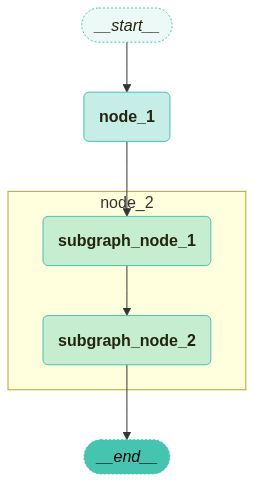

In [10]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph, xray=True)

In [11]:
# 그래프 스트리밍 처리를 통한 서브그래프 데이터 청크 단위 순차 출력
# subgraphs=True 옵션으로 하위 그래프 포함하여 스트림 데이터 처리
for chunk in graph.stream({"family_name": "Lee"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'family_name': 'Lee'}})
(('node_2:d2349a34-b152-650d-ee38-6ea813281f41',), {'subgraph_node_1': {'name': 'Teddy Lee'}})
(('node_2:d2349a34-b152-650d-ee38-6ea813281f41',), {'subgraph_node_2': {'name': 'My name is Teddy Lee'}})
((), {'node_2': {'full_name': 'My name is Teddy Lee'}})
